In [ ]:
# default_exp image_blending

# Image Blending

# Task 5: Image blending in gradient area

Implementujte techniku bezešvého skládání obrazů v gradientní oblasti. Pro výpočet výsledného lineárního systému použijte iterativní metodu Gauss-Seidel. Demonstrujte funkčnost výsledné implementace na příkladě složení dvou snímků se znatelně odlišnou úrovní expozice.

In [ ]:
# export
import numpy as np

In [ ]:
from tqdm import trange
import matplotlib.pyplot as plt
from dzotools.utils import imgload, arr2img
from IPython.display import clear_output

### Edge Padded Array
Neglect the borders by returning 0 if out of bounds. Wraps around a numpy array.

In [ ]:
# exports
class WrappedNdArray:
    """Wraps an ndarray and only returns value if within bounds."""
    def __init__(self, array: np.ndarray):
        self.array = array
        
    def is_inside(self, location):
        return all([
            0 <= location[0] < self.array.shape[0],
            0 <= location[1] < self.array.shape[1],
        ])
        
    def __getitem__(self, location):
        if self.is_inside(location):
            return self.array[location]
        return 0
        
    def __setitem__(self, location, value):
        if self.is_inside(location):
            self.array[location] = value

In [ ]:
wrapped = WrappedNdArray(
    np.array([[1, 2, 3], [4, 5, 6]])
)

assert wrapped[10, 0] == 0
assert wrapped[0, 0] == 1
assert wrapped[0, 1] == 2

### Laplacean operator
Implement laplace operator which computes the discrete laplace operator at given location coordinates.

$$
b[y, x] = -4 * s[y, x] + s[y+1, x] + s[y-1, x] + s[y, x+1] + s[y, x-1]
$$

In [ ]:
# exports
def laplace_op(y: int, x: int, arr: np.array) -> float:
    """Calculate the discrete Laplace operator on arr"""
    return -4 * arr[y, x] + arr[y+1, x] + arr[y-1, x] + arr[y, x+1] + arr[y, x-1]

In [ ]:
arr = np.array([
    [1, 1, 1, 1, 1],
    [1, 1, 1, 0, 1],
    [1, 1, 1, 1, 1],
])

assert laplace_op(1, 1, arr) == 0
assert laplace_op(1, 2, arr) == -1
assert laplace_op(1, 3, arr) == 4

### Prepare the data
Mask is $0$ if background should be kept. If mask is $1$, then we should be using the foreground and blend it with background.

In [ ]:
# exports
def prepare_target(bg: np.array, fg: np.array, msk: np.array) -> np.array:
    """Calculate the vector b used for Gauss-Seidel computation."""
    b = np.zeros_like(bg, dtype="float32")
    
    _fg = WrappedNdArray(fg)
    _bg = WrappedNdArray(bg)

    heigth, width = msk.shape
    for y in range(heigth):
        for x in range(width):
            if msk[y, x] == 1:
                b[y, x] = laplace_op(y, x, _fg)
            else:
                b[y, x] = laplace_op(y, x, _bg)            
    return b

### Utility functions

In [ ]:
# exports
def show_blending_parts(bg: np.array, fg: np.array, msk: np.array):
    """Visualize the background, foreground and a resulting 'hard' masked image without blending."""
    masked = np.where(msk[...,None], fg, bg)
    fig, ax = plt.subplots(ncols=4, figsize=(12, 4), sharey=True)
    ax[0].imshow(bg, vmin=0, vmax=1)
    ax[0].set_title("background")
    ax[1].imshow(fg, vmin=0, vmax=1)
    ax[1].set_title("foreground")
    ax[2].imshow(msk, vmin=0, vmax=1, cmap='gray')
    ax[2].set_title("mask")
    ax[3].imshow(masked, vmin=0, vmax=1)
    ax[3].set_title("hard-masked")
    plt.tight_layout()
    plt.show()

### Gauss-Seidel Iteration
Start with the image composed of the applied hard mask. Only update the masked indexes and keep refining the gradients.

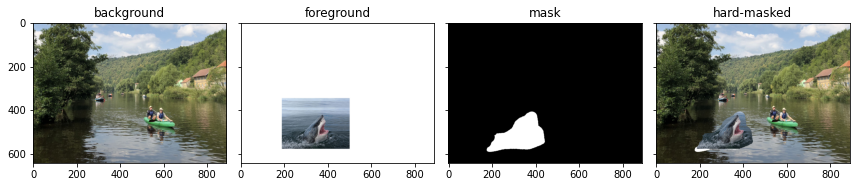

In [ ]:
vlt_bg = imgload('data/blending/vltava_bg.png') / 255.0
vlt_fg = imgload('data/blending/vltava_fr.png') / 255.0

# Load the mask and binarize it to 0, 1 and invert
vlt_msk = imgload('data/blending/vltava_mask.png', convert="L")
vlt_msk = 1 - np.round(vlt_msk / 255.0).astype(float)

show_blending_parts(vlt_bg, vlt_fg, vlt_msk)

In [ ]:
# exports
def gauss_seidel(
    bg: np.array, 
    fg: np.array, 
    msk: np.array,
    iteration_steps: int = 91,
    checkpoint_steps: int = 10,
) -> dict:
    """Perform gauss-sedel blending on the image.
    Store the results in a dictionary once in checkpoint_steps.
    Output starts as a background for faster convergence.
    Only iterate over masked values to speed up processing.
    """
    
    b = prepare_target(bg, fg, msk)
    masked_indexes = np.where(msk > 0.5)
    current = WrappedNdArray(bg.copy())
    
    results = {}
    for step in trange(iteration_steps):
        updated = current.array.copy()
        if step % checkpoint_steps == 0:
            results[step] = updated.copy()
            
        for y, x in zip(*masked_indexes):
            around = sum([
                current[y-1, x], 
                current[y+1, x], 
                current[y, x-1], 
                current[y, x+1]
            ])
            updated[y, x] = 0.25 * (around - b[y, x])
            
        current.array = np.clip(updated, 0, 1).copy()
        
    return results

```python
# Perform the gauss-seidel blending
results = gauss_seidel(vlt_bg, vlt_fg, vlt_msk, 901, 100)

# Save and show the results per step
fig, ax = plt.subplots(nrows=5, ncols=2, sharey=True, sharex=True, figsize=(10, 18))
for i, (step, result) in enumerate(results.items()):
    row, col = i // 2, i % 2
    ax[row, col].imshow(results[step], vmin=0, vmax=1)
    ax[row, col].set_title(f"step {step}")
plt.tight_layout()
plt.savefig("data/results/vlt_blend_steps.png")
plt.show()
```

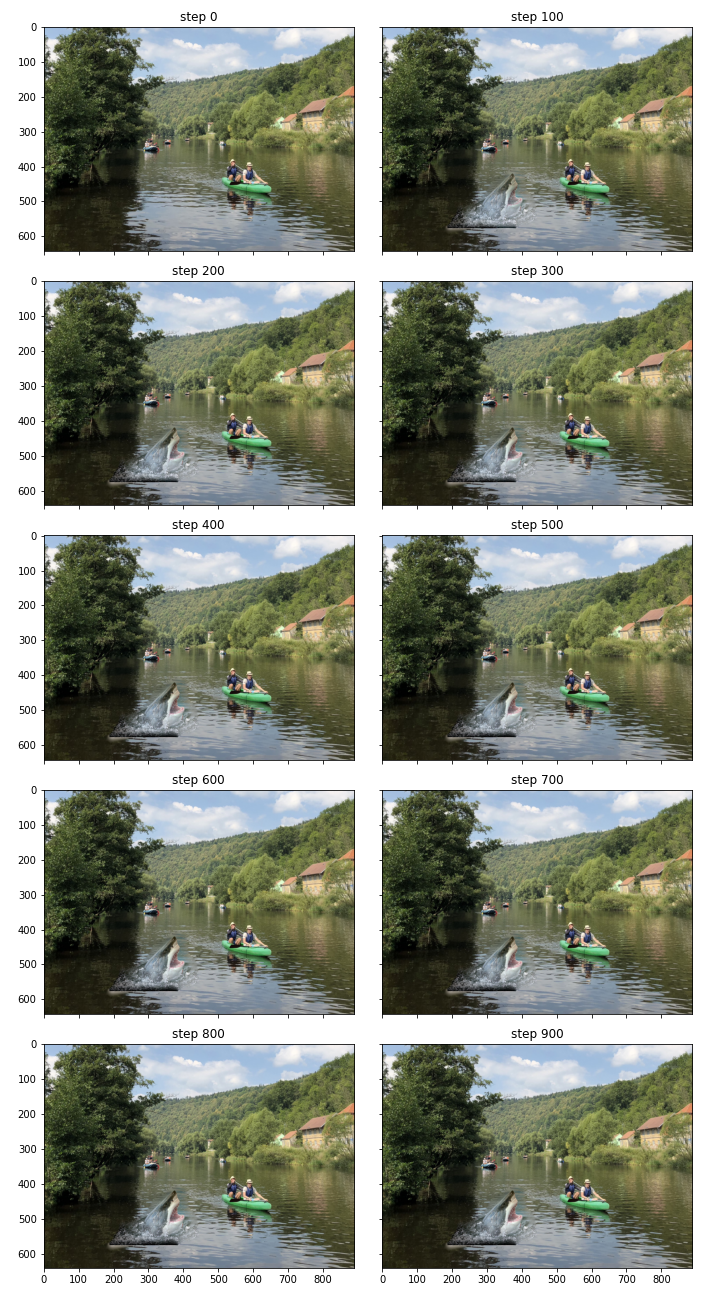

In [ ]:
arr2img(imgload('data/results/vlt_blend_steps.png'))

```python
# Show the resulting image after 900 iterations
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(results[900], vmin=0, vmax=1)
ax.set_title("Blended image after 900 steps")
plt.tight_layout(pad=0.05)
plt.savefig("data/results/vlt_blend_900.png")
plt.show()
```

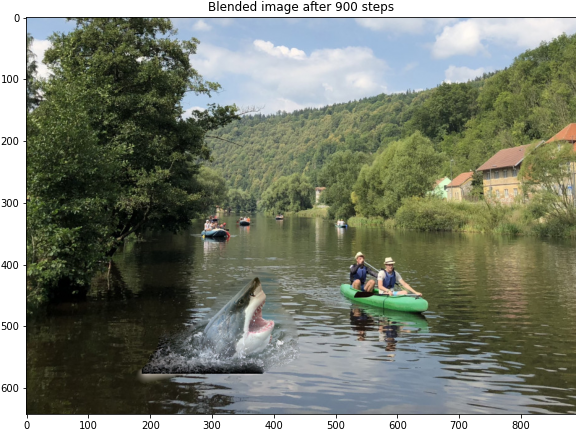

In [ ]:
arr2img(imgload('data/results/vlt_blend_900.png'))